# 🔎 Extração de Tópicos com BERTopic Padrão

Este notebook implementa um pipeline para clusterização de processos judiciais e consulta a LLM dos rotulos dos clusters , utilizando o modelo de tópicos **BERTopic** com redução de dimensionalidade via **UMAP** e clusterização com **HDBSCAN**.

---

## 📋 Etapas do Processo

### 1. **Consulta aos de Dados**
Consulta os dados dos processos judiciais que envolvem **Microempreendedores Individuais (MEI)**.

### 2. **Modelagem com BERTopic**
Para os dados de cada ramo:
- Foi utilizado o vetor `vetor_descricao_questoes` a como embeddings já calculados.
- Aplicou-se o modelo **BERTopic** com UMAP para redução para 2 dimensões.
- Tópicos foram extraídos automaticamente por meio do agrupamento com HDBSCAN.
- Cada documento foi rotulado com um número de tópico e os principais termos do grupo.
- 
### 3. **Visualizações diversas**
- Apresentadas várioas visualizações nativas ou não do BERTopic para o conjunto de tópicos sema distinção de ramo da justiça, sao 


## 📌 Objetivo
Identificar **temas recorrentes** nos processos judiciais envolvendo MEIs, com o intuito de auxiliar na análise da judicialização de políticas públicas e na tomada de decisão por gestores públicos.

### !IMPORTANTE! 
Necessário usar as bibliotecas nas versões do requirements.txt, leia o README antes.


In [139]:
import psycopg2
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sklearn.preprocessing import normalize
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import plotly.express as px
from hdbscan import HDBSCAN
from IPython.display import clear_output
import requests
import json
from psycopg2.extras import Json
from sklearn.cluster import KMeans
import colorsys
import ast
from sklearn.metrics.pairwise import cosine_distances
import hashlib, colorsys
from typing import List, Dict
import math
np.random.seed(42)

In [140]:
# Função para conectar ao PostgreSQL
def get_connection():
    return psycopg2.connect(
        dbname="PROCESSOS",
        user="",
        password="",
        host="localhost",
        port="5432"
    )

# Função para extrair os dados do banco com filtro opcional por ramo da justiça
def get_data():
    conn = get_connection()
    
    # Parte base da query
    query = """
        SELECT proc.id, descricao_caso, questoes_em_discussao, vetor_descricao_questoes, tese, dataajuizamento, ramo_justica, 
        vetor_descricao_questoes_testes_extracao, vetor_descricao_questoes_teste_plotagem
        FROM processos AS proc
        LEFT JOIN metadados_datajud AS meta 
        ON proc.numero_processo_tribunal = meta.numero_processo_tribunal
        WHERE descricao_caso IS NOT NULL 
          AND questoes_em_discussao IS NOT NULL 
          AND envolve_mei = 'Sim' 
    """
    df = pd.read_sql(query, conn)
    conn.close()
    return df

# Função para converter a string dos embeddings para vetor NumPy
def convert_embedding_string_to_vector(embedding_string):
    return np.array([float(x) for x in embedding_string[1:-1].split(',')])

# Variáveis globais para armazenar o token e o horário em que foi gerado
token = None
last_token_time = 0

# Função para obter o token da API
def get_token():
    client_id = ''
    client_secret = ''
    result = requests.request('POST', 
        "...", 
        #"https://e-api-serprollm.ni.estaleiro.serpro.gov.br/token",
        data={"grant_type":"client_credentials"}, 
        auth=(client_id, client_secret))

    if result.ok:
        return result.json()['access_token']
    else:
        raise Exception("Erro ao obter o token")

# Função para verificar se o token está expirado (renova se necessário)
def get_valid_token():
    global token, last_token_time
    current_time = time.time()
    
    # Se o token não existe ou já passaram mais de 20 minutos, obtemos um novo
    if token is None or (current_time - last_token_time) > 20 * 60:  # 20 minutos em segundos
        token = get_token()
        last_token_time = current_time
        print("Novo token obtido.")

    return token

# Função para invocar o LLM
def invoke(prompt, modelo,token, temperature=0, max_tokens=10000, stream=False):
    # Obtém o token válido (renova se necessário)
    

    payload_data = {
        "model": modelo,
        "messages": [{"role": "user", "content": prompt}],
        "temperature": temperature,
        "max_tokens": max_tokens,
        "stream": stream
    }

    result = requests.request("POST", 
        '...', 

        data=json.dumps(payload_data), 
        headers={
            "Authorization": f"Bearer {token}", 
            "Content-Type":"application/json"})

    if result.ok:
        res = result.json()
        resposta = res["choices"][0]["message"]['content']
        return resposta
    else:
        print(result.text)



# 📈 Funções de Visualização dos Tópicos

Este módulo define funções auxiliares para **visualizar a distribuição e a importância dos tópicos** identificados nos processos judiciais. São utilizadas diferentes formas gráficas para facilitar a análise exploratória dos clusters.

---

## 📊 `plot_topicos_barras`

- Gera um **gráfico de barras (histograma)** com a quantidade de processos por tópico.
- Tópicos com maior frequência aparecem no topo.
---

## 🌳 `plot_treemap_topicos`

- Cria um **gráfico de treemap**, onde cada área representa um tópico.
- A **área de cada bloco** é proporcional à **quantidade de processos** associados ao tópico.
---


In [141]:
def plot_topicos_barras(
    df_topicos,
    coluna_topico_num='numero_topico_LLM',
    coluna_topico_nome='Tópico LLM',
    top_n=10,
    incluir_noise=True
):
    """
    Plota os top N tópicos mais frequentes em um gráfico de barras.

    Parâmetros:
    - df_topicos: DataFrame com as colunas dos tópicos (nome e número)
    - coluna_topico_num: Nome da coluna com os números dos tópicos
    - coluna_topico_nome: Nome da coluna com os nomes/textos dos tópicos
    - top_n: Quantidade de tópicos mais frequentes a mostrar
    - incluir_noise: Se False, exclui o tópico -1 (ruído)

    Retorna:
    - None (apenas exibe o gráfico)
    """

    df = df_topicos.copy()

    if not incluir_noise:
        df = df[df[coluna_topico_num] != -1]

    # Agrupa e conta por número e nome
    contagem = df.groupby(
        [coluna_topico_num, coluna_topico_nome]
    ).size().reset_index(name='quantidade')

    # Ordena e filtra top N
    contagem = contagem.sort_values(by='quantidade', ascending=False).head(top_n)

    # Gera rótulo combinando número + nome do tópico
    contagem['label'] = contagem[coluna_topico_num].astype(str) + ' - ' + contagem[coluna_topico_nome]

    # Plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(contagem['label'], contagem['quantidade'], color='skyblue')

    # Rótulo em cima das barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}',
                 ha='center', va='bottom', fontsize=9, fontweight='bold')

    total = df.shape[0]
    plt.title(f'Tópicos Mais Frequentes (Top {top_n}) - Total de Registros: {total}', fontsize=14)
    plt.xlabel('Tópicos')
    plt.ylabel('Quantidade de Documentos')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()



def plot_treemap_topicos(
    df_topicos,
    coluna_topico_num='numero_topico_LLM',
    coluna_topico_nome='Tópico LLM',
    top_n=15,
    incluir_noise=False,
    titulo="Distribuição dos Tópicos (Treemap)"
):
    """
    Gera um gráfico de árvore (Treemap) para os tópicos mais frequentes.

    Parâmetros:
    - df_topicos: DataFrame com colunas dos tópicos
    - coluna_topico_num: Nome da coluna com número do tópico
    - coluna_topico_nome: Nome da coluna com nome/texto do tópico
    - top_n: Número de tópicos mais frequentes a exibir
    - incluir_noise: Se False, remove o tópico -1 (ruído)
    - titulo: Título do gráfico

    Retorna:
    - Figura do plotly (interativa)
    """
    df = df_topicos.copy()

    if not incluir_noise:
        df = df[df[coluna_topico_num] != -1]

    # Agrupamento e contagem
    contagem = df.groupby(
        [coluna_topico_num, coluna_topico_nome]
    ).size().reset_index(name='quantidade')

    # Ordenar pelos mais frequentes
    contagem = contagem.sort_values(by='quantidade', ascending=False).head(top_n)

    # Nome de exibição: número + descrição resumida
    contagem['topico'] = contagem.apply(
        lambda row: f"{row[coluna_topico_num]} - {row[coluna_topico_nome][:40]}...", axis=1
    )

    fig = px.treemap(
        contagem,
        path=['topico'],
        values='quantidade',
        color='quantidade',
        color_continuous_scale='RdBu',
        title=f"{titulo}<br><sup>Total de documentos considerados: {df.shape[0]}</sup>"
    )
    
    fig.update_traces(
        textinfo="label+value",
        hovertemplate="<b>%{label}</b><br>Quantidade: %{value}<extra></extra>"
    )
    fig.show()


# Funções para clusterização e rotulagem

Prompt padrão do bertopic, listado abaixo, foi alterado para um prompt mais adequado ao contexto, que será consultado no modelo PixTral 12B

"I have a topic that is described by
the following keywords: [KEYWORDS]
In this topic, the following
documents are a small but
representative subset of all
documents in the topic: [DOCUMENTS]
Based on the information above,
please give a description of this
topic in the following format:
topic: <description>"

In [142]:
def rotular_com_llm(documentos, keywords, token, rotulos_existentes):
    modelo = 'pixtral-12b'

    
    prompt = """Você é um assistente inteligente de extração de tópicos, especializado em nomear tópicos de forma curta, clara e amigável, com base em textos representativos e palavras-chave. 
Seu objetivo é criar um **rótulo conciso** que represente o problema central em comum dos conteúdos discutidos no tópico, facilitando a identificação do assunto por usuários finais. 

Siga as diretrizes abaixo:
- Não inclua o termo "MEI" no nome do tópico.
- O nome deve ter de 1 a 3 palavras.
- Não cite nome de pessoas, locais ou instituições.
"""
    prompt += "\n### Textos amostrados deste tópico:\n"
    for doc in documentos:
        prompt += f"- {doc}\n"

    prompt += f"\n### Palavras-chave: {keywords}\n\n"
    prompt += "Retorne apenas o nome curto do novo tópico, sem explicações ou pontuação adicional.\n"
    print(prompt)
    resposta = invoke(prompt, modelo, token)
   
    print(resposta)
    
    clear_output(wait=True)
    return resposta.strip()


In [143]:
#Antes de iniciar,limpar todos os dados dos clusters antigos 
def limpar_clusters(conn):
    # Limpa todos os dados de cluster antes de reprocessar
    cur_limpa = conn.cursor()
    cur_limpa.execute("""
        UPDATE processos SET 
            numero_topico_BERTopic_Padrao = NULL,
            descricao_topico_BERTopic_Padrao = NULL,
            descricao_topico_llm = NULL,
            numero_topico_llm = NULL,
            proximo_do_centroid = NULL,
            coordenadas_umap = NULL,
            descricao_curta_cluster = NULL,
            descricao_longa_cluster = NULL,
            questoes_discussao_cluster = NULL,
            solucoes_propostas_cluster = NULL,
            teses_cluster = NULL,
            descricao_topico_llm_ingles  = NULL,
            cor_cluster = NULL
    """)
    conn.commit()
    cur_limpa.close()
    print("🧹 Campos de cluster anteriores limpos.")


# Pipeline de Extração de Tópicos — Resumo

1. **Preparação dos dados**
   - Limpa clusters/atributos anteriores no banco (`limpar_clusters`).
   - Concatena `descricao_caso` + `questoes_em_discussao` → **corpus**.
   - Lê **embeddings** (`vetor_descricao_questoes_testes_extracao`) e **coordenadas 2D** (`vetor_descricao_questoes_teste_plotagem`) já do banco.
   - Converte strings de vetores para `np.ndarray` e aplica **máscara de linhas válidas**.

2. **Modelagem BERTopic (sem UMAP interno)**
   - Usa `BaseDimensionalityReduction`/`_IdentityDim` para **não reduzir novamente**.
   - Treinamento do Bertopic: `fit_transform(corpus_ok, X)` → `topics` (+ `probabilities`).

3. **Documentos representativos por tópico**
   - Para cada tópico ≠ `-1`:
     - Calcula **centróide** no espaço dos embeddings.
     - Distância cosseno documento–centróide.
     - Marca **N mais próximos** (`é próximo do centroid = 1`).

4. **Rotulagem via LLM**
   - Coleta textos dos docs mais próximos + **palavras-chave** do BERTopic.
   - Chama `rotular_com_llm(...)` → **“Tópico LLM”**.
   - Propaga o rótulo LLM a todos os docs do tópico.

5. **Mapeamentos finais**
   - `numero_topico_BERTopic_Padrao` (ID do BERTopic).
   - `descricao_topico_BERTopic_Padrao` (top-5 termos).
   - `numero_topico_LLM` a partir do rótulo LLM.
   - Define labels no modelo: `topic_model.set_topic_labels(...)`.

6. **Persistência no banco (opcional)**
   - Se `salvar == 'Sim'`, atualiza por linha válida:
     - `numero_topico_BERTopic_Padrao`, `descricao_topico_BERTopic_Padrao`
     - `descricao_topico_llm`, `numero_topico_llm`
     - `proximo_do_centroid`, `coordenadas_umap`
     - `cor_cluster` (usa a existente ou *fallback* do código)
   - **Commit** por registro + log progressivo.

7. **Saídas**
   - Retorna: `df` (atualizado), `topic_model`, `probabilities`, `corpus`, `timestamps`,
     `topics`, `reduced_embeddings (Xp)`, `embeddings`.

> **Notas**
> - As coordenadas de plotagem já vêm do banco: **não há UMAP adicional**.
> - Há um gerador de **cores distintas** (HLS + razão áurea) para consistência visual quando necessário.


In [144]:
# # Função usada na redução de dimencionalidade
class _IdentityDim:
    def fit(self, X, y=None): return self
    def transform(self, X): return X

# Função principal para extrair tópicos e atualizar o banco
def extract_topics_and_update_db(df, salvar='Não'):
    conn = get_connection()
    limpar_clusters(conn)
    n_clusters = 20
    frac_docs_por_topico = 0.30  # 30% por tópico
    timestamps = pd.to_datetime(df['dataajuizamento'], format="%Y-%m-%d", errors='coerce')

    # concatena descrição + questões (vetorizado, seguro p/ NaN)
    desc = df['descricao_caso'].astype('string').fillna('').str.strip()
    ques = df['questoes_em_discussao'].astype('string').fillna('').str.strip()
    
    # se ambos existem, junta com quebra de linha; senão usa o que tiver
    corpus = pd.Series(
        np.where((desc != '') & (ques != ''), desc + '\n\n' + ques, desc + ques),
        index=df.index,
        dtype='object'
    )

    #-------------RECEBER OS EMBEDDINGS DO BANCO, SEM CALCULAR ------------------
    # --- Converte inputs para Series para facilitar filtragem/alinhamento ---
    if not isinstance(corpus, (pd.Series, list)):
        raise ValueError("Passe 'corpus' como pandas Series ou lista de strings.")
    corpus = pd.Series(corpus, dtype="object")

    emb_col  = pd.Series(df['vetor_descricao_questoes_testes_extracao'], dtype="object")
    plot_col = pd.Series(df['vetor_descricao_questoes_teste_plotagem'], dtype="object")

    # >>> Parse: string "[...]" -> np.array <<<
    def _to_arr(v):
        if isinstance(v, (np.ndarray, list, tuple)):
            return np.asarray(v, dtype=np.float32)
        if isinstance(v, str):
            s = v.strip()
            if not s:
                return None
            # tenta lista Python
            try:
                return np.asarray(ast.literal_eval(s), dtype=np.float32)
            except Exception:
                # tenta JSON
                try:
                    return np.asarray(json.loads(s), dtype=np.float32)
                except Exception:
                    return None
        return None

    emb_col  = emb_col.apply(_to_arr)
    plot_col = plot_col.apply(_to_arr)

    # --- Máscaras de validade ---
    mask_texto = corpus.fillna("").str.strip().ne("")

    def _ok_vec(v, min_len=1):
        return isinstance(v, np.ndarray) and v.size >= min_len

    mask_emb  = emb_col.apply(lambda v: _ok_vec(v, 1))
    mask_plot = plot_col.apply(lambda v: _ok_vec(v, 2) and (np.asarray(v).shape[-1] >= 2))

    mask = mask_texto & mask_emb & mask_plot
    if mask.sum() == 0:
        raise ValueError("Nenhuma linha válida após filtrar texto/embeddings/plotagem.")

    if mask.sum() < len(corpus):
        print(f"ℹ️ Removidas {len(corpus) - mask.sum()} linhas inválidas (texto vazio/vetores ausentes).")

    # índices originais que passaram no filtro (para mapear de/para df)
    idx_valid = np.flatnonzero(mask.values)

    corpus_ok = corpus[mask].tolist()

    # Empilha embeddings (N, D) e plotagem (N, 2+)
    X  = np.vstack([np.asarray(v, dtype=np.float32) for v in emb_col[mask]])
    Xp = np.vstack([np.asarray(v, dtype=np.float32) for v in plot_col[mask]])

    # você usa 'embeddings' abaixo; prenda em X
    embeddings = X

    # --- BERTopic sem UMAP interno (não reduz de novo) ---
    try:
        dim_model = BaseDimensionalityReduction()   # oficial (não faz nada)
    except Exception:
        dim_model = _IdentityDim()                  # fallback compatível

    topic_model = BERTopic(
        verbose=True,
        language="portuguese",
        umap_model=dim_model,          # NÃO reduz dimensionalidade
        calculate_probabilities=False,
    )
    topics, probabilities = topic_model.fit_transform(corpus_ok, X)
    
    # =========================
    # CORES: utilitários e gerador estável e bem separado por RÓTULO
    # =========================

    
    # Paletas qualitativas consagradas (hex), ordenadas por distinção
    PALETTE_KELLY_22 = [
        "#F2F3F4", "#222222", "#F3C300", "#875692", "#F38400", "#A1CAF1",
        "#BE0032", "#C2B280", "#848482", "#008856", "#E68FAC", "#0067A5",
        "#F99379", "#604E97", "#F6A600", "#B3446C", "#DCD300", "#882D17",
        "#8DB600", "#654522", "#E25822", "#2B3D26"
    ]
    # Wong 18 (colorblind-friendly)
    PALETTE_WONG_18 = [
        "#000000","#E69F00","#56B4E9","#009E73","#F0E442","#0072B2",
        "#D55E00","#CC79A7","#999999","#117733","#44AA99","#88CCEE",
        "#DDCC77","#661100","#6699CC","#AA4466","#882255","#DDDDDD"
    ]
    # Okabe–Ito 8 (super seguras)
    PALETTE_OKABE_ITO_8 = [
        "#000000","#E69F00","#56B4E9","#009E73","#F0E442","#0072B2",
        "#D55E00","#CC79A7"
    ]
    
    def _hash_key(s: str) -> int:
        return int(hashlib.md5(s.encode("utf-8")).hexdigest(), 16)
    
    def _golden_fallback(n_needed: int, seed: float = 0.11):
        """Gera n_needed cores extras em HLS com espaçamento por ângulo áureo."""
        phi = 0.6180339887498949
        L_SEQ = (0.50, 0.65, 0.40)
        S_SEQ = (0.90, 0.75)
        out = []
        for k in range(n_needed):
            h = (seed + k * phi) % 1.0
            l = L_SEQ[k % len(L_SEQ)]
            s = S_SEQ[(k // len(L_SEQ)) % len(S_SEQ)]
            r, g, b = colorsys.hls_to_rgb(h, l, s)
            out.append("#{:02X}{:02X}{:02X}".format(int(r*255), int(g*255), int(b*255)))
        return out
    
    def build_distinct_color_map(labels: List[str], palette: str = "kelly") -> Dict[str, str]:
        """
        Retorna {rótulo: cor_hex} usando paletas qualitativas muito distintas.
        palette: "kelly" | "wong" | "okabe"
        """
        # normaliza rótulos
        norm = [(lab if lab and str(lab).strip() else "Tópico indefinido") for lab in labels]
        uniq = sorted(set(norm), key=lambda x: (_hash_key(x), x))  # ordem estável por hash
    
        # escolhe paleta base
        base = PALETTE_KELLY_22 if palette == "kelly" else (
            PALETTE_WONG_18 if palette == "wong" else PALETTE_OKABE_ITO_8
        )
    
        # se precisar de mais cores que a paleta, completa com fallback
        if len(uniq) > len(base):
            seed = (_hash_key("|".join(uniq)) % 360) / 360.0
            extra = _golden_fallback(len(uniq) - len(base), seed=seed)
            palette_full = base + extra
        else:
            palette_full = base
    
        # mapeia na ordem estável
        cmap = {lab: palette_full[i] for i, lab in enumerate(uniq)}
        return cmap
    # ================== FIM PALLETES + MAPA DE CORES DISTINTAS ==================

    # -------------- inicio extração do nome do topico via llm
    # Configurar número de documentos mais próximos do centro por tópico
    token = get_token()
    n_docs_por_topico = 30

    # Inicializar as colunas que serão preenchidas
    if 'Tópico LLM' not in df.columns:
        df['Tópico LLM'] = None
    if 'é próximo do centroid' not in df.columns:
        df['é próximo do centroid'] = 0

    # Para cada tópico válido
    topicos_unicos = set(topics)
    topicos_validos = [t for t in topicos_unicos if t != -1]

    for topico_id in topicos_validos:
        idx_topico = np.where(np.array(topics) == topico_id)[0]
        embeddings_topico = embeddings[idx_topico]
    
        # Centroide e distâncias
        centroide = np.mean(embeddings_topico, axis=0).reshape(1, -1)
        distancias = cosine_distances(embeddings_topico, centroide).flatten()
    
        # --- NOVO: número de docs por tópico baseado em porcentagem, com limites ---
        tam_topico = len(idx_topico)
        # candidato pela fração
        n_cand = int(math.ceil(frac_docs_por_topico * tam_topico))
        # aplica limites: mínimo 15 (ou menos, se o tópico for menor), máximo 100
        n_docs_por_topico = min(max(n_cand, 15), 150, tam_topico)
    
        # Índices dos N documentos mais próximos ao centroide
        indices_relativos_proximos = np.argsort(distancias)[:n_docs_por_topico]
        indices_absolutos = idx_topico[indices_relativos_proximos]
    
        # Mapear para índices originais do df
        indices_orig = [idx_valid[i] for i in indices_absolutos]
    
        # Marcar os documentos mais próximos no DataFrame
        df.loc[indices_orig, 'é próximo do centroid'] = 1
    
        # Textos + palavras-chave
        docs_topico = corpus.iloc[indices_orig].tolist()
        topic_words = topic_model.get_topic(topico_id) or []
        palavras_chave = [palavra for palavra, _ in topic_words]
    
        # Rótulo LLM
        rotulo = rotular_com_llm(docs_topico, palavras_chave, token, df['Tópico LLM'])
    
        # Propaga o rótulo ao tópico
        df.loc[[idx_valid[i] for i in idx_topico], 'Tópico LLM'] = rotulo


    # =========================
    # >>> AQUI: Atribuição de CORES POR RÓTULO LLM (NOVO)
    # =========================
    # rótulos da execução atual (somente linhas válidas)
    rotulos_exec = (
        df.loc[idx_valid, "Tópico LLM"]
          .fillna("")
          .astype(str)
          .str.strip()
          .replace("", "Tópico indefinido")
    )
    # gera mapa determinístico e bem separado
    mapa_cor_por_rotulo = build_distinct_color_map(rotulos_exec.tolist())
    # aplica a cor do rótulo em cada linha válida
    df.loc[idx_valid, "cor_cluster"] = rotulos_exec.map(mapa_cor_por_rotulo).values
    # =========================
    # FIM: cores por rótulo
    # =========================

    # Tópico numérico e descrição (somente nas linhas válidas)
    df.loc[idx_valid, 'numero_topico_BERTopic_Padrao'] = topics
    df.loc[idx_valid, 'descricao_topico_BERTopic_Padrao'] = [
        ', '.join([word for word, _ in (topic_model.get_topic(topic) or [])[:5]]) if topic != -1 else "Tópico indefinido"
        for topic in topics
    ]

    # Geração da coluna numero_topico_LLM
    rotulos_validos = df['Tópico LLM'].dropna().unique()
    rotulos_validos = [r for r in rotulos_validos if str(r).strip() != '']
    mapa_rotulos = {rotulo: i for i, rotulo in enumerate(rotulos_validos)}
    df['numero_topico_LLM'] = df['Tópico LLM'].apply(
        lambda x: mapa_rotulos.get(x, -1) if pd.notnull(x) and str(x).strip() != '' else -1
    )

    # Atualiza os rótulos no BERTopic para visualizações futuras
    mapa_rotulos_llm = {
        topico: df.loc[df['numero_topico_BERTopic_Padrao'] == topico, 'Tópico LLM'].dropna().unique()[0]
        for topico in topicos_validos
        if len(df.loc[df['numero_topico_BERTopic_Padrao'] == topico, 'Tópico LLM'].dropna().unique()) > 0
    }
    mapa_rotulos_llm[-1] = "Tópico indefinido"
    topic_model.set_topic_labels(mapa_rotulos_llm)

    # >>> NÃO calcular UMAP: vamos usar as coordenadas já fornecidas em Xp <<<
    reduced_embeddings = Xp  # (N_válidas, 2)

    if (salvar == 'Sim'):
        # Atualizar no banco (apenas linhas válidas, alinhadas ao reduced_embeddings)
        conn = get_connection()
        total = len(idx_valid)
        for j, i_abs in enumerate(idx_valid):
            row = df.iloc[i_abs]
            cur = conn.cursor()
            sql = """
                UPDATE processos 
                SET numero_topico_BERTopic_Padrao = %s,
                    descricao_topico_BERTopic_Padrao = %s,
                    descricao_topico_llm = %s,
                    numero_topico_llm = %s,
                    proximo_do_centroid = %s,
                    coordenadas_umap = %s,
                    cor_cluster = %s
                WHERE id = %s
            """

            x, y = reduced_embeddings[j]
            # sempre tipos nativos
            num_top_padrao = None
            if pd.notna(row['numero_topico_BERTopic_Padrao']) and int(row['numero_topico_BERTopic_Padrao']) != -1:
                num_top_padrao = int(row['numero_topico_BERTopic_Padrao'])

            desc_top = str(row['descricao_topico_BERTopic_Padrao']) if pd.notna(row['descricao_topico_BERTopic_Padrao']) else None
            desc_llm = (str(row['Tópico LLM']).strip() or None) if pd.notna(row['Tópico LLM']) else None

            num_top_llm = None
            if pd.notna(row['numero_topico_LLM']) and int(row['numero_topico_LLM']) != -1:
                num_top_llm = int(row['numero_topico_LLM'])

            prox_centroid = int(row['é próximo do centroid']) if pd.notna(row['é próximo do centroid']) else 0

            coordenadas = [float(x), float(y)]
            coord_param = coordenadas  # se sua coluna for JSONB, use psycopg2.extras.Json(coordenadas)

            # pega a cor já aplicada; se faltar, refaz pelo rótulo (fallback)
            if pd.notna(row.get('cor_cluster', None)) and str(row.get('cor_cluster')).strip():
                cor_hex = str(row['cor_cluster'])
            else:
                rotulo_txt = (str(row.get('Tópico LLM', '')).strip() or "Tópico indefinido")
                cor_hex = mapa_cor_por_rotulo.get(rotulo_txt, "#B0B0B0")

            params = (
                num_top_padrao,
                desc_top,
                desc_llm,
                num_top_llm,
                prox_centroid,
                coord_param,
                cor_hex,              # <-- usa a cor por rótulo
                int(row['id'])
            )
            cur.execute(sql, params)
            conn.commit()
            cur.close()
            clear_output(wait=True)
            print(f"📦 Processo {j+1} de {len(idx_valid)} salvo (ID {int(row['id'])})")

        conn.close()

    # Retorno usando as coordenadas já recebidas
    reduced_embeddings = Xp
    return df, topic_model, probabilities, corpus, timestamps, topics, reduced_embeddings, embeddings


In [145]:
df =  get_data()
df_with_topics, topic_model, probabilities,corpus,timestamps,topics,reduced_embeddings,embeddings = extract_topics_and_update_db(df, salvar = 'Sim')

📦 Processo 11775 de 11775 salvo (ID 10710)


In [146]:
# Conta tópicos válidos (diferentes de -1) do BERTopic
n_topicos_bertopic = df_with_topics['numero_topico_BERTopic_Padrao'].nunique()
n_topicos_bertopic_validos = df_with_topics[df_with_topics['numero_topico_BERTopic_Padrao'] != -1]['numero_topico_BERTopic_Padrao'].nunique()

# Conta tópicos válidos do LLM
n_topicos_llm = df_with_topics['numero_topico_LLM'].nunique()
n_topicos_llm_validos = df_with_topics[df_with_topics['numero_topico_LLM'] != -1]['numero_topico_LLM'].nunique()

# Imprime o resultado
print(f"Quantidade total de tópicos BERTopic (incluindo -1): {n_topicos_bertopic}")
print(f"Quantidade de tópicos BERTopic (válidos): {n_topicos_bertopic_validos}")
print(f"Quantidade total de tópicos LLM (incluindo -1): {n_topicos_llm}")
print(f"Quantidade de tópicos LLM (válidos): {n_topicos_llm_validos}")


Quantidade total de tópicos BERTopic (incluindo -1): 59
Quantidade de tópicos BERTopic (válidos): 58
Quantidade total de tópicos LLM (incluindo -1): 55
Quantidade de tópicos LLM (válidos): 54


In [147]:
df_with_topics

,id,descricao_caso,questoes_em_discussao,vetor_descricao_questoes,tese,dataajuizamento,ramo_justica,vetor_descricao_questoes_testes_extracao,vetor_descricao_questoes_teste_plotagem,Tópico LLM,é próximo do centroid,cor_cluster,numero_topico_BERTopic_Padrao,descricao_topico_BERTopic_Padrao,numero_topico_LLM
0,47077,Uma pessoa entrou com embargos à execução cont...,Foi discutido se o título executivo preenchia ...,"[-0.25154325,-0.24265775,0.48420408,0.08698164...",A cláusula de multa por rescisão unilateral em...,2023-08-25,Justiça Estadual,"[8.421827,1.5428829,7.687,6.386847,5.0135374]","[3.7323902,6.549887]",None,0,#DF1F64,-1.0,Tópico indefinido,-1
1,27882,"Angela Maria Miranda, uma microempreendedora i...",Foi discutido se a relação entre as partes era...,"[-0.40866718,-0.25491318,0.5138874,0.07471814,...",A relação entre microempreendedores e prestado...,2021-11-25,Justiça Estadual,"[8.50996,1.1559459,8.286508,6.2514873,5.1917663]","[4.279174,6.623517]",None,0,#DF1F64,-1.0,Tópico indefinido,-1
2,13795,Um trabalhador (S. H. B.) entrou com uma ação ...,Foi discutido se o trabalhador realmente era e...,"[-0.17097613,-0.13799326,0.6532423,0.095428236...",O tribunal concluiu que o trabalhador prestava...,2022-08-15,Justiça do Trabalho,"[10.328582,3.0848265,9.160054,0.8832931,5.047307]","[-3.613416,5.602477]",Vínculo Empregatício,0,#B21983,0.0,"trabalhador, vínculo, verbas, empregatício, tr...",0
3,13897,O caso trata de embargos declaratórios apresen...,Foi discutido se a mera declaração de hipossuf...,"[-0.19103809,-0.18698306,0.5067129,0.061796237...",A mera declaração de hipossuficiência econômic...,2023-06-02,Justiça do Trabalho,"[9.96549,1.1037167,5.5480347,4.823924,3.2120152]","[2.593704,1.6614494]",None,0,#DF1F64,-1.0,Tópico indefinido,-1
4,12385,O processo trata de uma sentença prolatada em ...,Foi discutido se o recurso ordinário foi inter...,"[-0.28772044,-0.16983889,0.3377584,0.10420877,...",O recurso ordinário deve ser recebido se inter...,2016-08-08,Justiça do Trabalho,"[9.165573,0.909424,5.9392433,2.809873,3.376423]","[-1.1044192,2.1279576]",Recursos Trabalhistas,0,#6F62E8,12.0,"recurso, interposto, ordinário, parte, depósito",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11770,38057,Um cliente comprou um microfone em uma loja e ...,Foi discutido se a loja deveria fornecer os ca...,"[-0.37769496,-0.23533307,0.2876998,0.083141826...",A falta de cabos não configura dano moral e a ...,1900-01-01,Justiça Estadual,"[8.222743,1.4956017,8.5259075,6.3979235,5.3316...","[4.7032886,6.249698]",None,0,#DF1F64,-1.0,Tópico indefinido,-1
11771,42608,Um trabalhador alegou que prestou serviços par...,Foi discutido se a contratação por meio de MEI...,"[-0.2409752,-0.06780451,0.48069188,0.058734417...",A contratação por meio de MEI não impede o rec...,2024-04-16,Justiça do Trabalho,"[10.240221,3.6752665,9.194156,0.883995,6.064355]","[-5.1644425,6.61926]",Vínculo Empregatício,0,#B21983,0.0,"trabalhador, vínculo, verbas, empregatício, tr...",0
11772,23254,Uma empresa MEI (Microempreendedor Individual)...,Foi discutido se a empresa MEI poderia ter dir...,"[-0.29174706,-0.2358161,0.3646216,0.12869382,0...","A justiça gratuita, incluindo a isenção de cus...",2017-04-20,Justiça do Trabalho,"[10.118056,0.92539775,6.2516446,4.1246214,2.75...","[1.5340252,1.8920774]",Justiça Gratuita,0,#1FDF3A,1.0,"justiça, gratuita, hipossuficiência, financeir...",3
11773,28036,Um trabalhador chamado Lucas Costa do Nascimen...,Foi discutido se o trabalhador tinha vínculo e...,"[-0.2925095,-0.14229143,0.4972408,0.08234117,0...",A Justiça do Trabalho não é competente para ju...,2024-07-30,Justiça do Trabalho,"[10.419863,3.085156,8.952434,1.0438957,4.8410487]","[-3.331594,5.288169]",Vínculo Empregatício,0,#B21983,0.0,"trabalhador, vínculo, verbas, empregatício, tr...",0


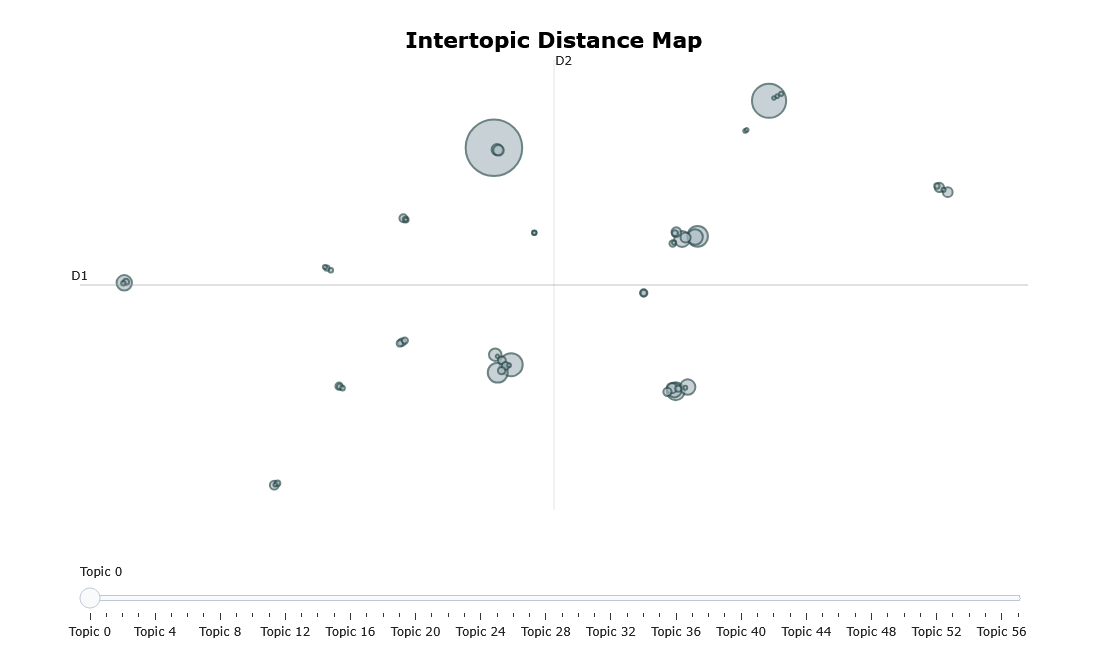

In [148]:
topic_model.visualize_topics()

In [149]:
topic_model.visualize_distribution(probabilities)

In [150]:
topic_model.visualize_barchart(top_n_topics=20, n_words = 10)

In [151]:
topic_model.visualize_hierarchy()

In [152]:
topic_model.get_topic_info()

,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,-1,3779,-1_de_foi_se_do,Tópico indefinido,"[de, foi, se, do, da, uma, que, para, um, mei]",[Um MEI entrou com uma ação contra um empregad...
1,0,2733,0_trabalhador_vínculo_verbas_empregatício,Vínculo Empregatício,"[trabalhador, vínculo, verbas, empregatício, t...",[Um trabalhador entrou com uma ação trabalhist...
2,1,999,1_justiça_gratuita_hipossuficiência_financeira,Justiça Gratuita,"[justiça, gratuita, hipossuficiência, financei...",[Um Microempreendedor Individual (MEI) entrou ...
3,2,456,2_taxas_complementar_taxa_lei,Isenção de Taxas para MEIs,"[taxas, complementar, taxa, lei, isenção, muni...",[Um MEI (Microempreendedor Individual) entrou ...
4,3,364,3_jucesp_registro_junta_comercial,Fraude Empresarial,"[jucesp, registro, junta, comercial, estado, f...",[Um indivíduo entrou com uma ação contra a Jun...
5,4,340,4_nacional_simples_regime_adesão,Adeção ao Simples Nacional,"[nacional, simples, regime, adesão, tributário...",[A J & E Aguiar Serviços e Equipamentos Ltda -...
6,5,275,5_desemprego_seguro_renda_união,Seguro-Desemprego e Renda,"[desemprego, seguro, renda, união, própria, be...",[A União recorreu contra uma sentença que julg...
7,6,213,6_conta_danos_morais_valores,Problemas Bancários,"[conta, danos, morais, valores, banco, indeniz...",[Um microempreendedor individual (MEI) entrou ...
8,7,203,7_personalidade_jurídica_desconsideração_bens,Confusão Patrimonial MEI,"[personalidade, jurídica, desconsideração, ben...",[Um empresário individual (MEI) entrou com um ...
9,8,202,8_tempo_aposentadoria_contribuição_períodos,Contribuições e Aposentadoria,"[tempo, aposentadoria, contribuição, períodos,...","[O autor, um MEI, entrou com um recurso contra..."


In [153]:
topic_model.visualize_heatmap(n_clusters=5)

In [154]:
topic_model.visualize_term_rank()

In [155]:
plot_treemap_topicos(df_with_topics, top_n=20, incluir_noise=False)